In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import deque
import network
import environment
import numpy as np

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
def memory_queue(memory,weight):
    weight = np.expand_dims(weight.T,axis=1)
    memory = np.concatenate((weight,memory),axis=2)[:,:,:-1]
    return memory

def MM_scaler(s):
    x= np.zeros(s.shape)
    for i in range(len(s)):
        x[i]=(s[i]-np.min(s[i],axis=0))/((np.max(s[i],axis=0)-np.min(s[i],axis=0))+1e-5)
    return x

def calculate_SV(value_list):
    value_array = np.array(value_list)/money
    return_array = np.log(value_array[1:]/value_array[:-1])
    SV=np.sqrt(np.var(return_array))
    SV = SV*np.sqrt(period)
    return SV

def sharpe_ratio(value_list,kospi):
    value_array = np.array(value_list)
    sigma = calculate_SV(value_list)
    APV = value_array[-1]
    excess_return = APV-kospi[-1]/kospi[0]
    sharpe_ratio = excess_return/sigma
    return sharpe_ratio
    
def beta(value,kospi):
    return_array = np.log(value[1:]/value[:-1])
    return_kospi = np.log(kospi[1:]/kospi[:-1])
    cov = np.cov(return_array,return_kospi)
    beta = cov[0,1]/cov[1,1]
    return beta

def MDD(apv):
    apv_max=[]
    apv_min=[]
    for i in range(1,period):
        apv_max.append(np.max(apv[:i]))
        apv_min.append(np.min(apv[np.argmax(apv[:i]):i]))
    drawdown = (np.array(apv_max) - np.array(apv_min))/np.array(apv_max)
    return drawdown

In [3]:
#preprocessed data loading
is_train = 0

#hyperparameters
input_day_size = 50
filter_size = 3
num_of_feature = 4
num_of_asset = 8
num_episodes = 10000 if is_train ==1 else 1
test_episodes = 2000
money = 1e+8
period = 1019 if is_train else 275

#saving
save_frequency = 100
save_path = './weights/'
save_model = 1
load_model = 1
selecting_random = False

env = environment.env(train = 0, number_of_asset = num_of_asset)

In [4]:
config = tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)
config.gpu_options.allow_growth = True

In [5]:
a_loss_sum = 0
s_loss_sum = 0
value_deque = deque()
AAM_deque = deque()

In [6]:
sess = tf.Session(config = config)

with tf.variable_scope('AAM'):
    allocator=network.policy(sess,num_of_asset = num_of_asset)
with tf.variable_scope('ESM'):    
    selector = network.select_network(sess)

sess.run(tf.global_variables_initializer())

saver_AAM = tf.train.Saver(var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'AAM'),max_to_keep=100)
ckpt_AAM = tf.train.get_checkpoint_state(save_path+'AAM/m_'+str(num_of_asset))
saver_ESM = tf.train.Saver(var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'ESM'),max_to_keep=100)
ckpt_ESM = tf.train.get_checkpoint_state(save_path+'ESM')

if load_model:
    saver_AAM.restore(sess,ckpt_AAM.model_checkpoint_path)
    saver_ESM.restore(sess,ckpt_ESM.model_checkpoint_path)

Device mapping:


Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Restoring parameters from ./weights/AAM/m_8\AAM-4999.cptk
INFO:tensorflow:Restoring parameters from ./weights/ESM\ESM-4999.cptk


In [7]:
score = 0
for i in range(num_episodes):
    allocator_memory = deque()
    selector_memory = deque()
    s=env.start()
    s=MM_scaler(s)
    done=False
    v=money
    weight_memory = []
    value_list = []
    bench_list = []
    while not done:
        evaluated_value = selector.predict(s)
        selected_s = env.selecting(evaluated_value,rand=selecting_random)
        selected_s = MM_scaler(selected_s)
        w = allocator.predict(selected_s)
        s_prime,r,done,v_prime,growth = env.action(w)
        s_prime=MM_scaler(s_prime)
        weight_memory.append(w)
        s = s_prime
        v = v_prime
        value_list.append(v)
        bench_list.append(env.benchmark)
        if done:
            value_deque.append(['AAM+ESM',value_list])
            value_deque.append(['ESM only',bench_list])
            score+=v/money
            print(i,'agent:',round(v/money,4), 'benchmark:',round(env.benchmark/money,4))

0 agent: 1.9026 benchmark: 1.7585


In [8]:
for i in range(test_episodes):
    value_list = []
    allocator_memory = deque()
    s=env.start()
    s = MM_scaler(s)
    done = False
    v = money
    while not done:
        selected_s = env.selecting(evaluated_value, rand = True)
        selected_s = MM_scaler(selected_s)
        w = allocator.predict(selected_s)
        s_prime,r,done,v_prime,growth = env.action(w)
        s_prime = MM_scaler(s_prime)
        s = s_prime
        v = v_prime
        value_list.append(v)
        if done:
            AAM_deque.append(value_list)
            score+=v/money
            print(i,'agent:',round(v/money,4), 'benchmark:',round(env.benchmark/money,4))

0 agent: 0.9142 benchmark: 1.242
1 agent: 0.8614 benchmark: 1.0748
2 agent: 1.5238 benchmark: 1.896
3 agent: 1.1094 benchmark: 1.0963
4 agent: 0.9826 benchmark: 1.1599
5 agent: 1.0748 benchmark: 1.1884
6 agent: 6.3764 benchmark: 2.5884
7 agent: 1.1906 benchmark: 1.1037
8 agent: 1.4389 benchmark: 1.2133
9 agent: 1.6362 benchmark: 1.1841
10 agent: 0.8218 benchmark: 0.9888
11 agent: 0.8124 benchmark: 1.0486
12 agent: 0.9809 benchmark: 0.9876
13 agent: 1.2649 benchmark: 1.2565
14 agent: 1.6981 benchmark: 1.3173
15 agent: 0.7096 benchmark: 0.9735
16 agent: 1.14 benchmark: 1.3494
17 agent: 0.765 benchmark: 1.0294
18 agent: 1.0865 benchmark: 1.0175
19 agent: 1.5023 benchmark: 1.4509
20 agent: 1.3387 benchmark: 1.1634
21 agent: 1.5581 benchmark: 1.5562
22 agent: 1.4596 benchmark: 1.5665
23 agent: 1.8147 benchmark: 1.6909
24 agent: 0.8472 benchmark: 1.171
25 agent: 1.3256 benchmark: 1.2883
26 agent: 1.1132 benchmark: 1.3049
27 agent: 0.9786 benchmark: 1.1964
28 agent: 0.6386 benchmark: 1.1855
2

233 agent: 0.926 benchmark: 1.8518
234 agent: 0.7575 benchmark: 0.9118
235 agent: 1.278 benchmark: 1.3159
236 agent: 1.5707 benchmark: 1.5131
237 agent: 0.7757 benchmark: 0.9836
238 agent: 1.181 benchmark: 1.4426
239 agent: 1.1841 benchmark: 1.0099
240 agent: 1.0305 benchmark: 0.8521
241 agent: 0.9445 benchmark: 1.1029
242 agent: 1.4808 benchmark: 1.2316
243 agent: 1.0223 benchmark: 0.9557
244 agent: 0.9501 benchmark: 1.113
245 agent: 1.7813 benchmark: 2.5714
246 agent: 1.1009 benchmark: 1.5959
247 agent: 1.2117 benchmark: 1.3414
248 agent: 1.6063 benchmark: 1.3457
249 agent: 1.0298 benchmark: 1.1714
250 agent: 1.0336 benchmark: 1.1379
251 agent: 1.0444 benchmark: 1.2077
252 agent: 1.1673 benchmark: 1.0828
253 agent: 1.5381 benchmark: 1.3874
254 agent: 1.1192 benchmark: 1.2759
255 agent: 1.0503 benchmark: 1.25
256 agent: 1.564 benchmark: 1.2953
257 agent: 1.0708 benchmark: 1.1282
258 agent: 1.4951 benchmark: 1.1687
259 agent: 1.1847 benchmark: 1.7647
260 agent: 1.0027 benchmark: 1.3513

463 agent: 0.7446 benchmark: 1.0458
464 agent: 0.8493 benchmark: 1.0046
465 agent: 1.4988 benchmark: 1.3295
466 agent: 1.2034 benchmark: 1.036
467 agent: 0.8498 benchmark: 1.0105
468 agent: 1.0584 benchmark: 1.2079
469 agent: 4.3904 benchmark: 1.9454
470 agent: 1.2119 benchmark: 1.3011
471 agent: 0.9103 benchmark: 1.1936
472 agent: 0.7695 benchmark: 1.0545
473 agent: 0.8907 benchmark: 1.2442
474 agent: 0.5656 benchmark: 0.8066
475 agent: 0.966 benchmark: 1.295
476 agent: 1.0369 benchmark: 1.1973
477 agent: 1.2265 benchmark: 1.5632
478 agent: 1.3696 benchmark: 1.4705
479 agent: 0.9033 benchmark: 1.2986
480 agent: 1.5748 benchmark: 1.5265
481 agent: 1.0754 benchmark: 1.2798
482 agent: 1.0374 benchmark: 1.222
483 agent: 1.188 benchmark: 1.4787
484 agent: 1.2912 benchmark: 1.317
485 agent: 1.4989 benchmark: 1.4639
486 agent: 1.0995 benchmark: 1.5676
487 agent: 1.3857 benchmark: 1.2505
488 agent: 0.6863 benchmark: 1.2167
489 agent: 1.1731 benchmark: 1.1603
490 agent: 1.4257 benchmark: 1.099

692 agent: 0.708 benchmark: 1.1052
693 agent: 0.8289 benchmark: 1.0738
694 agent: 1.0048 benchmark: 1.3144
695 agent: 1.4517 benchmark: 1.3825
696 agent: 1.3763 benchmark: 1.5696
697 agent: 1.4484 benchmark: 1.3797
698 agent: 1.5767 benchmark: 1.1259
699 agent: 1.6513 benchmark: 1.419
700 agent: 1.27 benchmark: 2.5228
701 agent: 0.8757 benchmark: 1.2052
702 agent: 1.3358 benchmark: 1.3291
703 agent: 1.0741 benchmark: 1.4167
704 agent: 0.8092 benchmark: 0.9939
705 agent: 0.7482 benchmark: 1.109
706 agent: 0.9085 benchmark: 1.2014
707 agent: 1.5549 benchmark: 1.6189
708 agent: 0.7474 benchmark: 1.2293
709 agent: 1.5048 benchmark: 1.3213
710 agent: 0.5856 benchmark: 0.8289
711 agent: 0.8923 benchmark: 0.7653
712 agent: 0.9483 benchmark: 1.2146
713 agent: 1.0398 benchmark: 1.1522
714 agent: 1.174 benchmark: 1.275
715 agent: 0.948 benchmark: 0.9407
716 agent: 1.3711 benchmark: 1.408
717 agent: 1.0946 benchmark: 1.2037
718 agent: 1.2104 benchmark: 1.346
719 agent: 0.859 benchmark: 0.8205
720

922 agent: 1.0075 benchmark: 1.1902
923 agent: 0.9163 benchmark: 1.0776
924 agent: 0.8424 benchmark: 1.1109
925 agent: 1.156 benchmark: 1.2075
926 agent: 0.6266 benchmark: 1.0381
927 agent: 0.7216 benchmark: 0.9227
928 agent: 1.0197 benchmark: 1.0515
929 agent: 1.3407 benchmark: 1.448
930 agent: 1.0131 benchmark: 0.9849
931 agent: 3.0193 benchmark: 2.3068
932 agent: 1.6065 benchmark: 1.3506
933 agent: 0.8932 benchmark: 1.1382
934 agent: 1.2037 benchmark: 1.3766
935 agent: 1.2892 benchmark: 1.3582
936 agent: 1.1205 benchmark: 1.1749
937 agent: 0.8624 benchmark: 1.1172
938 agent: 0.8431 benchmark: 1.1764
939 agent: 1.0777 benchmark: 0.9331
940 agent: 1.0185 benchmark: 1.086
941 agent: 1.0277 benchmark: 1.3063
942 agent: 0.9358 benchmark: 1.0823
943 agent: 0.7687 benchmark: 1.0516
944 agent: 0.9326 benchmark: 1.1992
945 agent: 0.9939 benchmark: 0.8813
946 agent: 1.5819 benchmark: 1.475
947 agent: 0.8603 benchmark: 1.102
948 agent: 1.2993 benchmark: 1.0872
949 agent: 1.5812 benchmark: 1.18

1147 agent: 2.0794 benchmark: 1.7682
1148 agent: 1.0425 benchmark: 1.3772
1149 agent: 0.7779 benchmark: 0.7785
1150 agent: 0.9319 benchmark: 1.118
1151 agent: 0.7309 benchmark: 0.952
1152 agent: 2.7623 benchmark: 2.456
1153 agent: 1.0438 benchmark: 1.2285
1154 agent: 0.8591 benchmark: 1.0083
1155 agent: 1.1662 benchmark: 1.3649
1156 agent: 1.5609 benchmark: 1.3947
1157 agent: 0.761 benchmark: 1.1613
1158 agent: 1.244 benchmark: 2.3305
1159 agent: 1.4077 benchmark: 1.5991
1160 agent: 0.6255 benchmark: 0.9366
1161 agent: 1.1584 benchmark: 1.031
1162 agent: 0.5445 benchmark: 0.9115
1163 agent: 2.2241 benchmark: 1.5439
1164 agent: 0.4834 benchmark: 0.6117
1165 agent: 9.1918 benchmark: 2.7955
1166 agent: 0.8693 benchmark: 0.991
1167 agent: 0.8161 benchmark: 1.1928
1168 agent: 0.7917 benchmark: 1.1776
1169 agent: 1.123 benchmark: 1.0961
1170 agent: 0.9281 benchmark: 1.0888
1171 agent: 0.8074 benchmark: 1.0062
1172 agent: 1.0856 benchmark: 1.5338
1173 agent: 0.7694 benchmark: 0.8723
1174 agen

1371 agent: 0.9505 benchmark: 1.1508
1372 agent: 0.7756 benchmark: 1.0625
1373 agent: 0.9741 benchmark: 0.9546
1374 agent: 1.2522 benchmark: 1.3579
1375 agent: 0.8694 benchmark: 1.1144
1376 agent: 0.7117 benchmark: 0.9884
1377 agent: 0.9927 benchmark: 1.0312
1378 agent: 0.8777 benchmark: 1.1863
1379 agent: 1.6268 benchmark: 1.3225
1380 agent: 1.3037 benchmark: 1.3092
1381 agent: 1.0162 benchmark: 1.2201
1382 agent: 0.8693 benchmark: 1.3072
1383 agent: 1.1549 benchmark: 1.2077
1384 agent: 1.2747 benchmark: 1.0964
1385 agent: 0.8765 benchmark: 1.054
1386 agent: 1.3638 benchmark: 1.2042
1387 agent: 1.356 benchmark: 1.1117
1388 agent: 0.977 benchmark: 1.5458
1389 agent: 0.8567 benchmark: 0.951
1390 agent: 1.5359 benchmark: 1.1156
1391 agent: 0.9747 benchmark: 1.0245
1392 agent: 0.8749 benchmark: 1.2295
1393 agent: 1.2291 benchmark: 1.3981
1394 agent: 1.4525 benchmark: 1.2463
1395 agent: 1.6979 benchmark: 1.3561
1396 agent: 0.7973 benchmark: 0.8576
1397 agent: 1.0736 benchmark: 1.2742
1398 

1594 agent: 1.2771 benchmark: 3.3995
1595 agent: 1.1229 benchmark: 0.9374
1596 agent: 0.9282 benchmark: 1.383
1597 agent: 1.0437 benchmark: 1.2579
1598 agent: 1.8032 benchmark: 1.8659
1599 agent: 0.8778 benchmark: 1.3391
1600 agent: 1.4294 benchmark: 1.0699
1601 agent: 1.9213 benchmark: 1.6231
1602 agent: 1.3916 benchmark: 1.4425
1603 agent: 0.8987 benchmark: 1.1293
1604 agent: 1.7735 benchmark: 1.5381
1605 agent: 0.731 benchmark: 0.7906
1606 agent: 0.9177 benchmark: 1.0175
1607 agent: 0.7614 benchmark: 1.1457
1608 agent: 0.7974 benchmark: 1.1776
1609 agent: 0.9023 benchmark: 1.0273
1610 agent: 1.1524 benchmark: 1.1967
1611 agent: 1.6928 benchmark: 1.3487
1612 agent: 1.3161 benchmark: 1.3302
1613 agent: 0.7442 benchmark: 1.0902
1614 agent: 0.9098 benchmark: 1.3839
1615 agent: 1.7508 benchmark: 1.6826
1616 agent: 0.9234 benchmark: 1.0927
1617 agent: 1.2112 benchmark: 1.2103
1618 agent: 1.0187 benchmark: 1.1852
1619 agent: 1.1714 benchmark: 1.2025
1620 agent: 0.9995 benchmark: 1.1984
162

1817 agent: 1.1635 benchmark: 0.9555
1818 agent: 0.8799 benchmark: 1.0332
1819 agent: 1.4026 benchmark: 1.487
1820 agent: 1.1616 benchmark: 1.2361
1821 agent: 1.1025 benchmark: 1.1856
1822 agent: 1.2477 benchmark: 1.1868
1823 agent: 0.7368 benchmark: 1.044
1824 agent: 0.7252 benchmark: 1.1898
1825 agent: 1.9641 benchmark: 1.292
1826 agent: 1.1262 benchmark: 1.0428
1827 agent: 1.1442 benchmark: 1.3504
1828 agent: 1.4879 benchmark: 1.9712
1829 agent: 1.0598 benchmark: 1.1149
1830 agent: 1.1701 benchmark: 1.1527
1831 agent: 0.8889 benchmark: 1.0819
1832 agent: 0.8399 benchmark: 2.3782
1833 agent: 1.1011 benchmark: 1.3021
1834 agent: 1.0514 benchmark: 1.062
1835 agent: 0.8176 benchmark: 0.9598
1836 agent: 1.055 benchmark: 1.2745
1837 agent: 1.0279 benchmark: 1.2787
1838 agent: 1.648 benchmark: 1.5531
1839 agent: 1.0823 benchmark: 1.302
1840 agent: 1.3254 benchmark: 1.2592
1841 agent: 0.8917 benchmark: 0.9393
1842 agent: 1.0131 benchmark: 1.1616
1843 agent: 1.0268 benchmark: 1.162
1844 agen

In [9]:
import benchmark
import pandas as pd

value_array = np.array(value_deque[0][1])
ESM_value_array = np.array(value_deque[1][1])
AAM_mean_deque = deque()
AAM_array = np.array(AAM_deque)
for i in range(env.time):
    AAM_mean_deque.append(np.mean(AAM_array[:,i]))
AAM_mean_array = np.array(AAM_mean_deque)
AAM_mean_array

k200price = pd.read_csv("./data/KOSPI200index.csv")
k200 = k200price[['종가']].to_numpy(dtype=np.float32)
k200 = k200[1:-1]
k200 = k200[::-1]

benchmark = benchmark.benchmark(num_of_asset = num_of_asset)
ucrp,ubah = benchmark.execute(iteration=test_episodes)
UCRP = np.mean(ucrp,axis = 0)
UBAH = np.mean(ubah,axis = 0)

best = env.env_data.loaded_list[86][50:-1,0]
best = best/env.env_data.loaded_list[86][49,0]

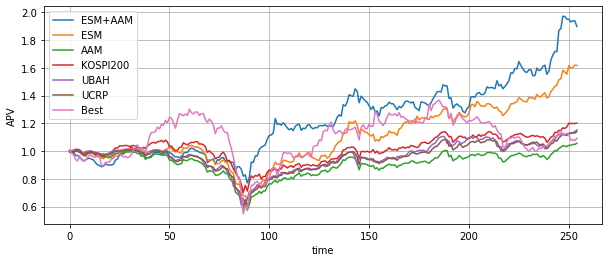

In [10]:
plt.figure(figsize = (10,4))
plt.grid(1)
plt.plot(value_array[:-19]/money,label='ESM+AAM')
plt.plot(ESM_value_array[:-19]/money,label = 'ESM')
plt.plot(AAM_mean_array[:-19]/money,label = 'AAM')
plt.plot(k200[:-19]/k200[0],label='KOSPI200')
plt.plot(UBAH[:-19]/money,label = 'UBAH')
plt.plot(UCRP[:-19]/money,label = 'UCRP')
plt.plot(best[:-19],label = 'Best')
plt.xlabel("time")
plt.ylabel("APV")
plt.legend()
plt.show()

In [11]:
value_array= value_array[:-19]
ESM_value_array = ESM_value_array[:-19]
AAM_mean_array = AAM_mean_array[:-19]
k200 = k200[:-19]
UBAH = UBAH[:-19]
UCRP = UCRP[:-19]
best = best[:-19]

base_rate = np.array(np.loadtxt('./data/base_rate_test.csv',delimiter=',',dtype = str)[1:][:,1],dtype =np.float32)

In [12]:
print('esm+aam:',np.max(MDD(value_array/money)))
print('aam:',np.max(MDD(ESM_value_array/money)))

mdd_ucrp_list = []    
for i in ucrp:
    mdd_ucrp_list.append(np.max(MDD(i[:-19]/money)))
print('ucrp:',np.mean(np.array(mdd_ucrp_list)))

mdd_ubah_list = []
for i in ubah:
    mdd_ubah_list.append(np.max(MDD(i[:-19]/money)))
    
print('ubah:',np.mean(np.array(mdd_ubah_list)))

mdd_aam_list=[]
for i in AAM_array:
    mdd_aam_list.append(np.max(MDD(i[:-19]/money)))
    
print('aam:',np.mean(np.array(mdd_aam_list)))

esm+aam: 0.25335214
aam: 0.37920788
ucrp: 0.4209729
ubah: 0.4151641
aam: 0.4631927


In [13]:
print('ksp:',k200[-1]/k200[0])
print('best:',best[-1])
print('esm+aam:',value_array[-1]/money)
print('esm:',ESM_value_array[-1]/money)
print('ucrp:',UCRP[-1]/money)
print('ubah:',UBAH[-1]/money)
print('aam:',AAM_mean_array[-1]/money)

ksp: [1.2008461]
best: 1.0922331
esm+aam: 1.89729968
esm: 1.61732672
ucrp: 1.13956808
ubah: 1.15304656
aam: 1.05691136


In [14]:
Rf = [1.0,1.008]
print(sharpe_ratio(value_array/money,Rf))
print(sharpe_ratio(ESM_value_array/money,Rf))

sr_ubah_list = []    
for i in ubah:
    sr_ubah_list.append(sharpe_ratio(i[:-19]/money,Rf))
print('ubah:',np.mean(np.array(sr_ubah_list)))

sr_ucrp_list = []    
for i in ucrp:
    sr_ucrp_list.append(sharpe_ratio(i[:-19]/money,Rf))
print('ucrp:',np.mean(np.array(sr_ucrp_list)))

sr_aam_list = []    
for i in AAM_array:
    sr_aam_list.append(sharpe_ratio(i[:-19]/money,Rf))
print('aam:',np.mean(np.array(sr_aam_list)))

2.276630209664954
ubah: 0.3713705810089701
ucrp: 0.3687764017814301
aam: 0.1043548685233651


In [15]:
print(sharpe_ratio(ESM_value_array/money,Rf))

1.8630099682048435


In [16]:
print('ESM+aam:',calculate_SV(value_array))
print('ESM:',calculate_SV(ESM_value_array))
print('best:',calculate_SV(best))
print('ksp:',calculate_SV(k200/k200[0]))

sv_ucrp_list = []    
for i in ucrp:
    sv_ucrp_list.append(calculate_SV(i[:-19]/money))
print('ucrp:',np.mean(np.array(sv_ucrp_list)))

sv_ubah_list = []
for i in ubah:
    sv_ubah_list.append(calculate_SV(i[:-19]/money))

print('ubah:',np.mean(np.array(sv_ubah_list)))

sv_aam_list=[]
for i in AAM_array:
    sv_aam_list.append(calculate_SV(i[:-19]/money))

print('aam:',np.mean(np.array(sv_aam_list)))

ESM+aam: 0.3906210652382365
ESM: 0.3270657722689842
best: 0.5775155848550355
ksp: 0.2940536833097194
ucrp: 0.36104356825264516
ubah: 0.371597833824663
aam: 0.4244228224260673
